# 確率ロボティクスの勉強

## ロボットのシミュレーション

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm

import math
import numpy as np


In [3]:
class World:
    def __init__(self):
        self.objects = []
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5,5)
        
        for obj in self.objects:
            obj.draw(ax)
        plt.show()
    

<IPython.core.display.Javascript object>


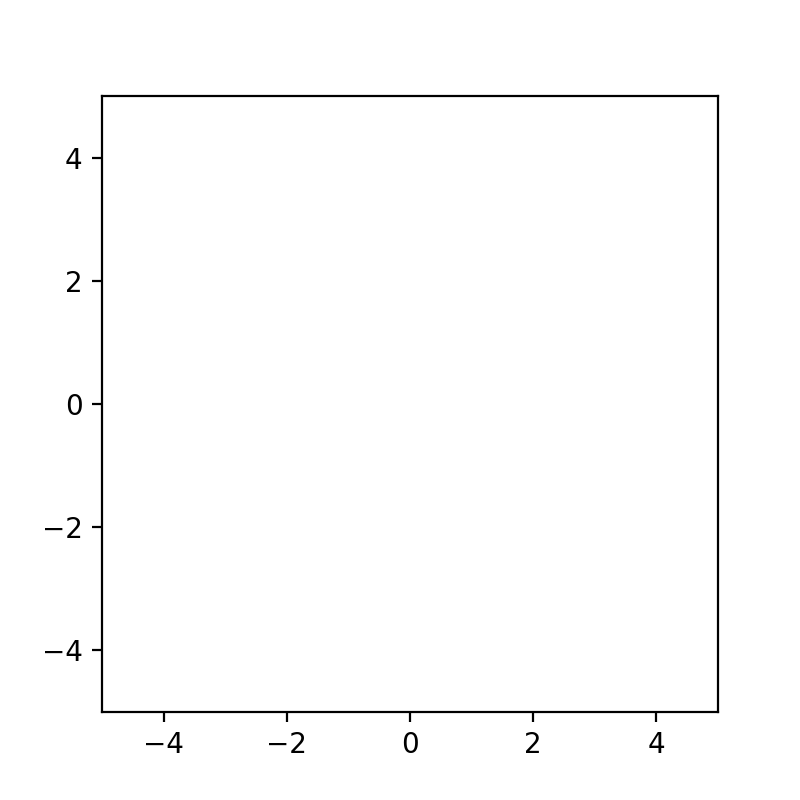

In [4]:
world = World()
world.draw()

In [5]:
class MyRobot:
    def __init__(self, pose, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
    def draw(self, ax):
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        ax.add_patch(robot)

<IPython.core.display.Javascript object>


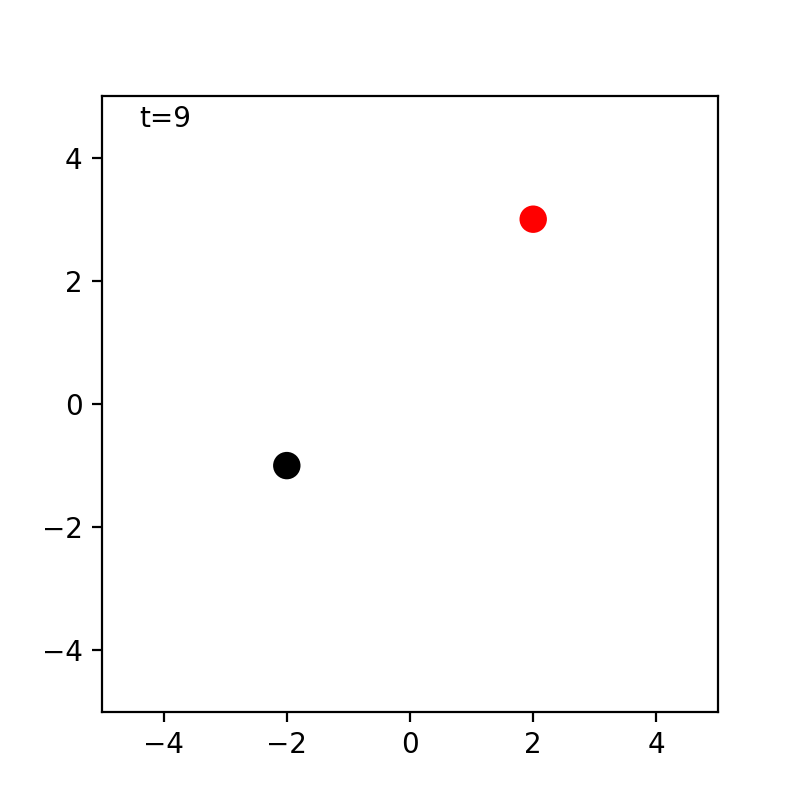

In [25]:
world = World()

robot1 = MyRobot(np.array([2,3]))
robot2 = MyRobot(np.array([-2,-1]), "black")
world.append(robot1)
world.append(robot2)
world.draw()

### アニメーション化

In [11]:
class World:
    def __init__(self):
        self.objects = []
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        
        elems = []
        
        self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=10, interval=1000, repeat=False)
        plt.show()
    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t="+str(i), fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)

In [23]:
class MyRobot:
    def __init__(self, pose, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
    def draw(self, ax, elems):
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))

<IPython.core.display.Javascript object>


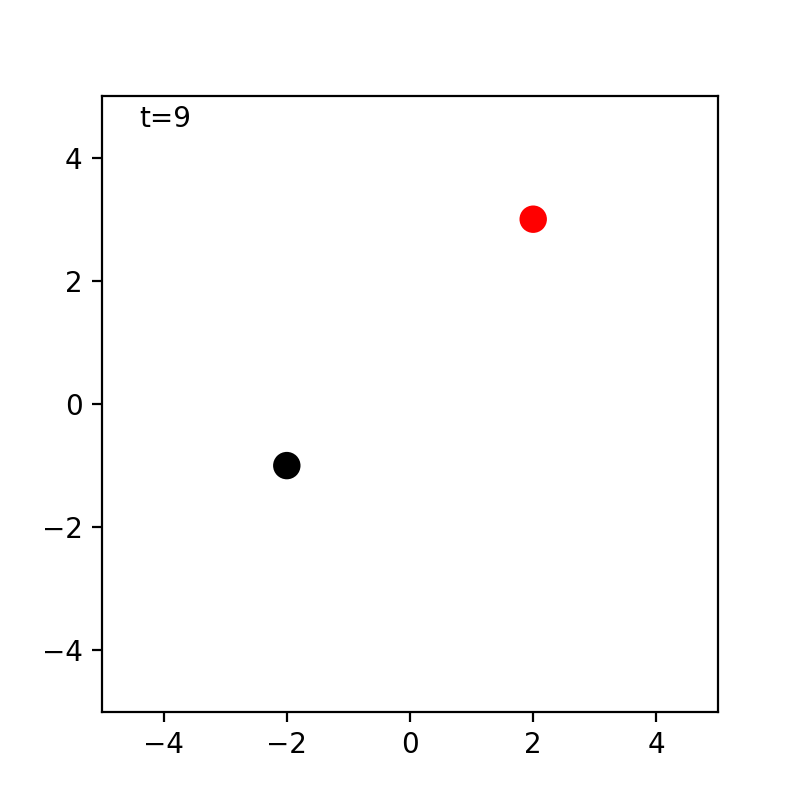

In [24]:
world = World()

robot1 = MyRobot(np.array([2,3]))
robot2 = MyRobot(np.array([-2,-1]), "black")
world.append(robot1)
world.append(robot2)
world.draw()

### 状態遷移の実装

In [21]:
class MyRobot:
    def __init__(self, pose, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        
    def draw(self, ax, elems):
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))
        
    def state_transition(self, v_x, v_y, time): #x軸の速度, y軸の速度, 移動時間
        self.pose = self.pose + np.array([v_x*time, v_y*time]) 
    
    

In [31]:
my_robot = MyRobot(np.array([2,3]))
print(my_robot.pose)
my_robot.state_transition(2,3,1)
print(my_robot.pose)

[2 3]
[4 6]


### エージェントの実装

In [203]:
class World:
    def __init__(self, time_span, time_interval, debug=False): #シミュレーション時間, シミュレーション更新周期
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        
        elems = []
        
        self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
        plt.show()
    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t=%.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

In [193]:
class MyRobot:
    def __init__(self, pose, agent=None, sensor=None, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [] #移動の軌跡を保存
        self.sensor = sensor
        
    def draw(self, ax, elems):
       
        #初期値or状態遷移後のposeを取得
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))
        
        self.poses.append(np.array([x,y]).T)
        poses_x = [e[0] for e in self.poses]
        poses_y = [e[1] for e in self.poses]
        elems += ax.plot(poses_x, poses_y, linewidth=0.5, color="black")
        
        if self.sensor and len(self.poses) > 1:
            #状態遷移前の姿勢で観測しているのでposes[-2] (一つ前の姿勢値から線分の計算)
            self.sensor.draw(ax, elems, self.poses[-2])
        
    def state_transition(self, v_x, v_y, time): #x軸の速度, y軸の速度, 移動時間
        self.pose += np.array([v_x*time, v_y*time])
    
    def one_step(self, time_interval):
        if self.agent:
            #観測
            obs = self.sensor.data(self.pose) if self.sensor else None
            # >>> 現在の姿勢と観測結果がわかった状態
            
            #エージェントによる制御値の決定
            v_x, v_y = self.agent.decision(obs)
            
            #状態遷移
            self.state_transition(v_x, v_y, time_interval)
            # >>> 現在の姿勢が更新, 観測はまだ
            

In [197]:
class Agent:
    def __init__(self, v_x, v_y):
        self.v_x = v_x
        self.v_y = v_y
        self.counter =0
    
    def decision(self, observation=None):
        self.counter += 1
        return self.v_x, self.v_y

<IPython.core.display.Javascript object>


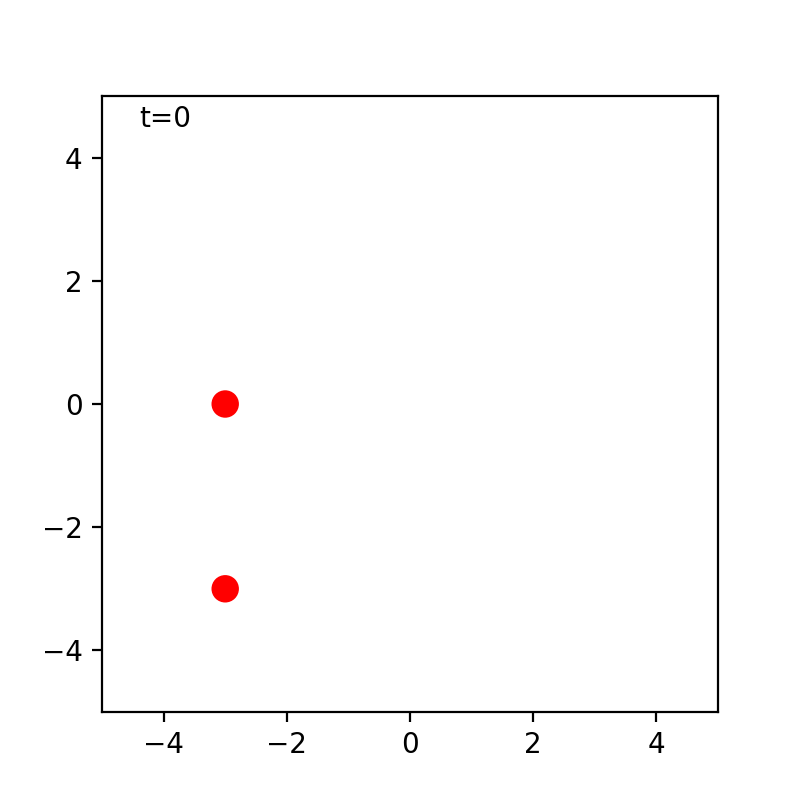

In [191]:
world = World(10,1)
agent1 = Agent(0.5,0.0)
agent2 = Agent(0.5,0.5)
robot1 = MyRobot(np.array([-3.0, 0.0]).T, agent1)
robot2 = MyRobot(np.array([-3.0, -3.0]).T, agent2,"black")
world.append(robot1)
world.append(robot2)
world.draw()

### 点ランドマークの実装 

In [184]:
class Landmark:
    def __init__(self, x, y):
        self.pos=np.array([x,y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))

In [185]:
class Map:
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks)
        self.landmarks.append(landmark)
    
    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

<IPython.core.display.Javascript object>


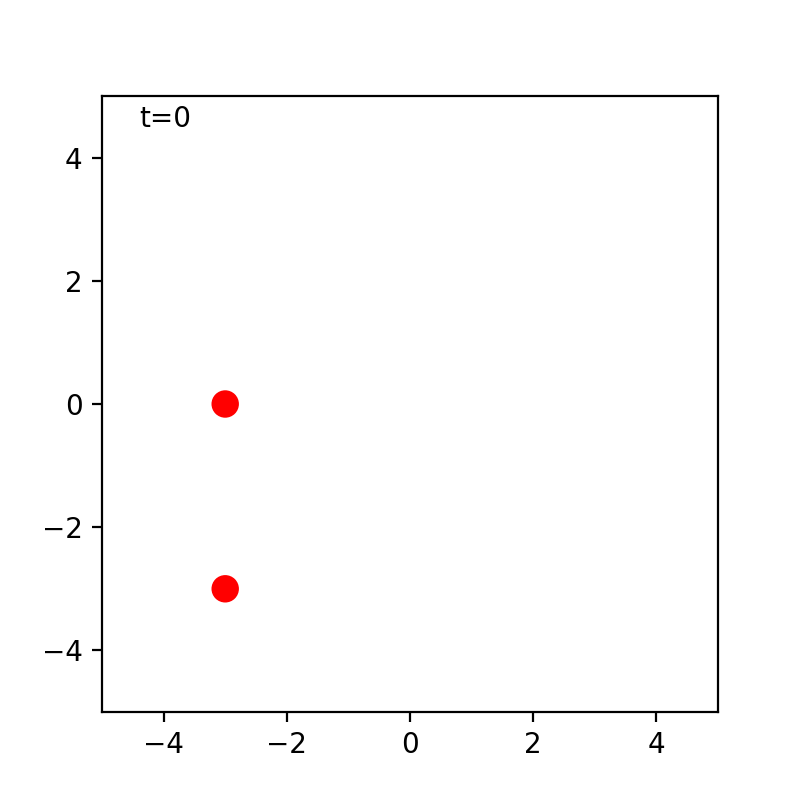

In [186]:
world = World(10, 1)


agent1 = Agent(0.5,0.0)
agent2 = Agent(0.5,0.5)
robot1 = MyRobot(np.array([-3.0, 0.0]).T, agent1)
robot2 = MyRobot(np.array([-3.0, -3.0]).T, agent2,"black")
world.append(robot1)
world.append(robot2)

m = Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)
world.draw()

### 観測の実装

In [222]:
class MyCamera:
    def __init__(self, env_map, distance_range = (0.5, 6)):
        self.map = env_map
        self.lastdata = []
        self.distance_range = distance_range
    
    def visible(self, pos):
        if pos is None:
            return False
        
        distance = np.hypot(*pos)
        return self.distance_range[0] <= distance <= self.distance_range[1]
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
        
        self.lastdata = observed
        return observed
    
    def observation_function(self, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        return np.array(diff).T
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y = cam_pose
            lx = lm[0][0] + x
            ly = lm[0][1] + y
            elems += ax.plot([x,lx],[y,ly], color="pink")
        

In [221]:
m = Map()
m.append_landmark(Landmark(2.0,-2.0))
m.append_landmark(Landmark(-1.0,-3.0))
m.append_landmark(Landmark(3.0,3.0))
cam = MyCamera(m)
robot1 = MyRobot(np.array([0.0, 0.0]).T)
print(cam.data(robot1.pose))


[(array([ 2., -2.]), 0), (array([-1., -3.]), 1)]


<IPython.core.display.Javascript object>


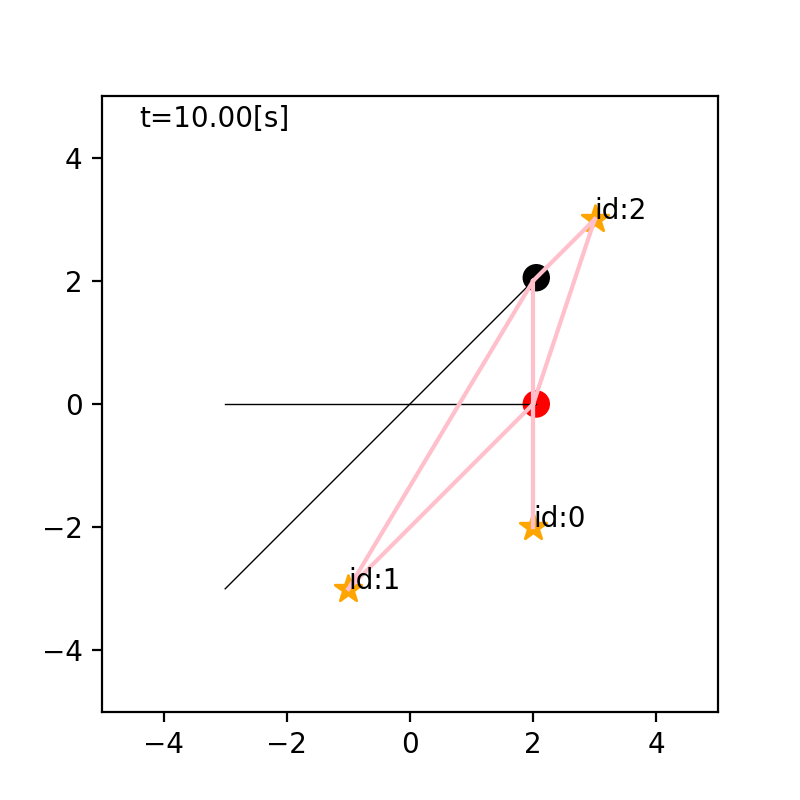

In [204]:
world = World(10, 0.1)

m = Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

agent1 = Agent(0.5,0.0)
agent2 = Agent(0.5,0.5)
robot1 = MyRobot(np.array([-3.0, 0.0]).T, sensor=MyCamera(m), agent=agent1)
robot2 = MyRobot(np.array([-3.0, -3.0]).T, sensor=MyCamera(m), agent=agent2, color="black")
world.append(robot1)
world.append(robot2)




world.draw()

 ## 最終的な実装

In [223]:
class World:
    '''
    シミュレーション全体の管理
    '''
    def __init__(self, time_span, time_interval, debug=False): #シミュレーション時間, シミュレーション更新周期
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        
        elems = []
        
        self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
        plt.show()
    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t=%.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

In [224]:
class MyRobot:
    '''
    ロボット1台の処理関係
    agentとsensorを含む
    '''
    def __init__(self, pose, agent=None, sensor=None, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [] #移動の軌跡を保存
        self.sensor = sensor
        
    def draw(self, ax, elems):
       
        #初期値or状態遷移後のposeを取得
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))
        
        self.poses.append(np.array([x,y]).T)
        poses_x = [e[0] for e in self.poses]
        poses_y = [e[1] for e in self.poses]
        elems += ax.plot(poses_x, poses_y, linewidth=0.5, color="black")
        
        if self.sensor and len(self.poses) > 1:
            #状態遷移前の姿勢で観測しているのでposes[-2] (一つ前の姿勢値から線分の計算)
            self.sensor.draw(ax, elems, self.poses[-2])
        
    def state_transition(self, v_x, v_y, time): #x軸の速度, y軸の速度, 移動時間
        self.pose += np.array([v_x*time, v_y*time])
    
    def one_step(self, time_interval):
        if self.agent:
            #観測
            obs = self.sensor.data(self.pose) if self.sensor else None
            # >>> 現在の姿勢と観測結果がわかった状態
            
            #エージェントによる制御値の決定
            v_x, v_y = self.agent.decision(obs)
            
            #状態遷移
            self.state_transition(v_x, v_y, time_interval)
            # >>> 現在の姿勢が更新, 観測はまだ

In [225]:
class Agent:
    '''
    ロボットの動作を決定する, agent(操縦者)としてRobotに登録する
    '''
    def __init__(self, v_x, v_y):
        self.v_x = v_x
        self.v_y = v_y
        self.counter =0
    
    def decision(self, observation=None):
        self.counter += 1
        return self.v_x, self.v_y

In [226]:
class Landmark:
    '''
    観測地点のデータ, Mapに登録する
    '''
    def __init__(self, x, y):
        self.pos=np.array([x,y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))

In [227]:
class Map:
    '''
    Landmarkを管理する
    '''
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks)
        self.landmarks.append(landmark)
    
    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

In [228]:
class MyCamera:
    '''
    観測を管理する, sensorとしてRobotに登録する
    '''
    def __init__(self, env_map, distance_range = (0.5, 6)):
        self.map = env_map
        self.lastdata = []
        self.distance_range = distance_range
    
    def visible(self, pos):
        if pos is None:
            return False
        
        distance = np.hypot(*pos)
        return self.distance_range[0] <= distance <= self.distance_range[1]
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
        
        self.lastdata = observed
        return observed
    
    def observation_function(self, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        return np.array(diff).T
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y = cam_pose
            lx = lm[0][0] + x
            ly = lm[0][1] + y
            elems += ax.plot([x,lx],[y,ly], color="pink")